In [1]:
DATA_CSV = "../results/decision_transitions.csv"

GENERATE_DATA = False
# Parameters for generating data
MODEL_DIRECTORY = "../models/random_nk3"
UPDATE = "asynchronous"
N_RANDOM = 30 # number of random models
DEBUG = False
NSQUARE_STEPS = 20 # number of steps for nsquare

# Figure configuration
SUP_FIGURE_ID = "s7"
METRICS = ["precision", "recall", "specificity", "npv"]
METHODS = None # plot all methods
FIGURE_DIR = "../results/figures"

In [2]:
import pandas as pd
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.prime_implicants import percolate
from pyboolnet.state_transition_graphs import primes2stg

import sdmarkov.plotting.config as pc
from sdmarkov.decisions import get_decision_matrix, expand_decision_matrix, compare_decision_matrices
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.matrix_operations import compress_matrix
from sdmarkov.transition_matrix import get_transition_matrix
from sdmarkov.attractors import get_predicted_attractors
from sdmarkov.analysis.utils import load_or_generate_data, add_classification_metrics, network_level_metrics_df
from sdmarkov.plotting.figures import plot_violin_figure, plot_distribution_figure, save_figure

## Data generation or loading

In [3]:
def get_data_decision_transitions(
    bnet,
    bnet_name=None,
    update="asynchronous",
    num_runs=30,
    DEBUG=False,
):
    """
    Compare decision transition matrices between full, grouped,
    and random groupings of a Boolean network.

    Returns
    -------
    pd.DataFrame
        Long-format table with columns:
        bnet, method, run, TP, FP, TN, FN
    """

    rows = []

    primes = bnet_text2primes(bnet)
    primes = {k: primes[k] for k in sorted(primes)}

    # Percolate constant nodes
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return pd.DataFrame(rows)

    percolated_bnet = primes2bnet(percolated_primes)
    n_states = 2 ** len(percolated_primes)

    # --- full transition matrix ---
    stg = primes2stg(percolated_primes, update)
    T = get_transition_matrix(stg, DEBUG=DEBUG)
    decisions = get_decision_matrix(T, DEBUG=DEBUG)

    # --- grouped transition matrices ---
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)

    # Predicted attractors
    predicted_attractor_indices = get_predicted_attractors(Tsd, sd_indices, as_indices=True, DEBUG=DEBUG)
    n_attractors = len(predicted_attractor_indices)

    if n_attractors < 2:
        return pd.DataFrame(rows)

    # --- helper: add row ---
    def add_row(method, T_grouped, indices, run=None):
        grouped_decision_matrix = get_decision_matrix(
            T_grouped, indices, DEBUG=DEBUG
        )
        grouped_decision_expanded = expand_decision_matrix(
            grouped_decision_matrix, indices, DEBUG=DEBUG
        )
        TP, FP, TN, FN = compare_decision_matrices(
            decisions, grouped_decision_expanded, DEBUG=DEBUG
        )
        rows.append({
            "bnet": bnet_name,
            "method": method,
            "run": run,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "n_states": n_states,
            "n_attractors": n_attractors,
            "update_scheme": update
        })

    # --- deterministic methods ---
    add_row("sd_mc", Tsd, sd_indices)
    add_row("null_mc", Tnull, null_indices)

    # --- random baseline ---
    for i in range(num_runs):
        random_indices = random_grouping(
            sd_indices, null_indices, seed=i, DEBUG=DEBUG
        )
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        add_row("random_mc", Trandom, random_indices, run=i)

    return pd.DataFrame(rows)

In [4]:
df = load_or_generate_data(
    data_csv=DATA_CSV,
    generate_data=GENERATE_DATA,
    data_function=get_data_decision_transitions,
    model_directory=MODEL_DIRECTORY,
    update=UPDATE,
    n_random=N_RANDOM,
    debug=DEBUG,
)

Loaded cached results from ../results/decision_transitions.csv.


In [5]:
print("Preview of results DataFrame:")
display(df.head())

print("\nDataFrame shape:", df.shape)
print("Methods present:", df.method.unique())
print("Number of unique networks:", df.bnet.nunique())

Preview of results DataFrame:


,bnet,method,run,TP,FP,TN,FN,n_states,n_attractors,update_scheme
0,n010_000.bnet,sd_mc,NaN,480,0,5152,0,1024,2,asynchronous
1,n010_000.bnet,null_mc,NaN,32,160,4992,448,1024,2,asynchronous
2,n010_000.bnet,random_mc,0.0,32,160,4992,448,1024,2,asynchronous
3,n010_000.bnet,random_mc,1.0,32,160,4992,448,1024,2,asynchronous
4,n010_000.bnet,random_mc,2.0,32,160,4992,448,1024,2,asynchronous



DataFrame shape: (1472, 10)
Methods present: ['sd_mc' 'null_mc' 'random_mc']
Number of unique networks: 46


## Data analysis

In [6]:
# filter out networks with a single attractor
df_multi = df[df["n_attractors"] > 1].copy()

# add precision, recall, specificity, and NPV
df_multi = add_classification_metrics(df_multi)

print("\nAdded classification metrics")
print("DataFrame shape:", df_multi.shape)
print("Methods present:", df_multi.method.unique())
print("Number of unique networks:", df_multi.bnet.nunique())

display(df_multi.head())


Added classification metrics
DataFrame shape: (1472, 14)
Methods present: ['sd_mc' 'null_mc' 'random_mc']
Number of unique networks: 46


,bnet,method,run,TP,FP,TN,FN,n_states,n_attractors,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,sd_mc,NaN,480,0,5152,0,1024,2,asynchronous,1.000000,1.000000,1.000000,1.000000
1,n010_000.bnet,null_mc,NaN,32,160,4992,448,1024,2,asynchronous,0.166667,0.066667,0.968944,0.917647
2,n010_000.bnet,random_mc,0.0,32,160,4992,448,1024,2,asynchronous,0.166667,0.066667,0.968944,0.917647
3,n010_000.bnet,random_mc,1.0,32,160,4992,448,1024,2,asynchronous,0.166667,0.066667,0.968944,0.917647
4,n010_000.bnet,random_mc,2.0,32,160,4992,448,1024,2,asynchronous,0.166667,0.066667,0.968944,0.917647


In [7]:
df_metrics = network_level_metrics_df(df=df_multi)

print("Preview of network-level metrics DataFrame:")
display(df_metrics.head())

print("\nDataFrame shape:", df_metrics.shape)
print("Methods present:", df_metrics.method.unique())
print("Number of unique networks:", df_metrics.bnet.nunique())

print("\nNetwork-level classification metrics:")
metrics = ["precision", "recall", "specificity", "npv"]
summary = (
    df_metrics
    .groupby("method")[metrics]
    .agg(["mean", "min", "median", "max"])
)

display(summary)

Preview of network-level metrics DataFrame:


,bnet,method,TP,FP,TN,FN,n_states,n_attractors,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,null_mc,32.0,160.0,4992.0,448.0,1024.0,2.0,asynchronous,0.166667,0.066667,0.968944,0.917647
1,n010_000.bnet,random_mc,32.0,160.0,4992.0,448.0,1024.0,2.0,asynchronous,0.166667,0.066667,0.968944,0.917647
2,n010_000.bnet,sd_mc,480.0,0.0,5152.0,0.0,1024.0,2.0,asynchronous,1.000000,1.000000,1.000000,1.000000
3,n010_001.bnet,null_mc,12.0,12.0,164.0,36.0,64.0,5.0,asynchronous,0.500000,0.250000,0.931818,0.820000
4,n010_001.bnet,random_mc,12.0,12.0,164.0,36.0,64.0,5.0,asynchronous,0.500000,0.250000,0.931818,0.820000



DataFrame shape: (138, 13)
Methods present: ['null_mc' 'random_mc' 'sd_mc']
Number of unique networks: 46

Network-level classification metrics:


precision                             recall                      \
               mean       min    median  max      mean       min    median   
method                                                                       
null_mc    0.404752  0.000000  0.363971  1.0  0.165238  0.008421  0.101648   
random_mc  0.406631  0.000000  0.363971  1.0  0.171101  0.008421  0.102610   
sd_mc      0.912280  0.428571  0.972522  1.0  0.807685  0.085938  0.899541   

               specificity                               npv            \
           max        mean       min   median  max      mean       min   
method                                                                   
null_mc    1.0    0.964356  0.800000  0.99084  1.0  0.906435  0.636364   
random_mc  1.0    0.964431  0.811111  0.99084  1.0  0.908114  0.713114   
sd_mc      1.0    0.992356  0.920455  1.00000  1.0  0.981240  0.870968   

                          
             median  max  
method                    
null_mc    0.917810  1.0  
random_mc  0.917810  1.0  
sd_mc      0.997261  1.0

## Plotting

In [8]:
pc.apply_style()

PosixPath('../results/figures/Figure_s7_Decision_transitions.png')

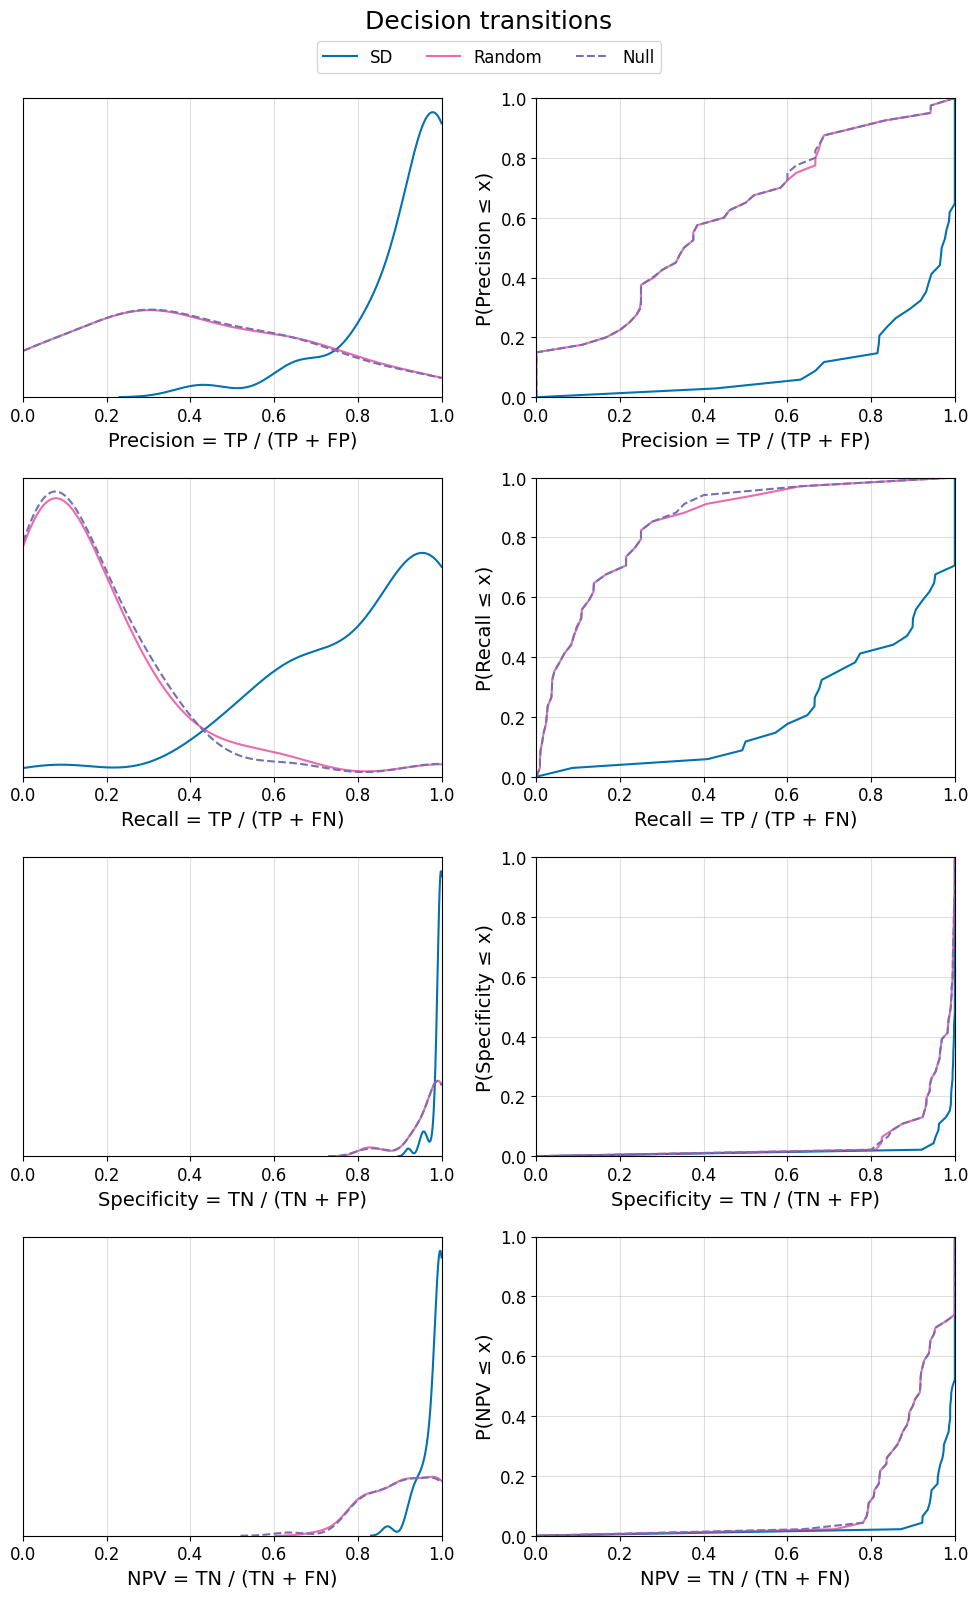

In [9]:
fig = plot_distribution_figure(df_metrics, metrics=METRICS, figure_id=SUP_FIGURE_ID, legend_loc=0.985, layout_top=0.99)

save_figure(fig, figure_id=SUP_FIGURE_ID, outdir=FIGURE_DIR)